In [50]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.base import BaseEstimator
import pickle

class PCAIsolationForest(BaseEstimator):
    def __init__(self, n_pca_components=1, n_estimators = 100, random_state = None, contamination='auto', bootstrap=False):
        self.n_pca_components = n_pca_components
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.contamination = contamination
        self.bootstrap = bootstrap
        self.model = IsolationForest(n_estimators=n_estimators, random_state=random_state, contamination=contamination, bootstrap=bootstrap)
        self.scaler = StandardScaler(with_std=True, with_mean=True)

    def _get_pca_scores(self, data):
        scaled = self.scaler.fit_transform(data)
        pca = PCA(self.n_pca_components)
        return pca.fit_transform(scaled)
    
    def fit(self, X, y=None):
        data = self._get_pca_scores(X)
        self.model.fit(data, y)
        return self

    def predict(self, X):
        data = self._get_pca_scores(X)
        anomaly = self.model.predict(data)
        return (anomaly == -1)

## Load data

In [4]:
train_X = pd.read_pickle('../../pickled_data/wavelet_pickle_data/2022/X_train.pkl').sort_index()
train_y = pd.read_pickle('../../pickled_data/wavelet_pickle_data/2022/y_train.pkl').sort_index()['Redox_error_flag']
test_X = pd.read_pickle('../../pickled_data/wavelet_pickle_data/2022/X_test.pkl').sort_index()
test_y = pd.read_pickle('../../pickled_data/wavelet_pickle_data/2022/y_test.pkl').sort_index()['Redox_error_flag']
test_2023 = pd.read_pickle('../../pickled_data/wavelet_pickle_data/2023/test.pkl').sort_index()
pit_train_X = []
pit_train_y = []
pit_test_X = []
pit_test_y = []
pit_test_2023 = []
for d in range(1,6):
    pit_train_X.append(pd.read_pickle(f'../../pickled_data/wavelet_pickle_data/2022_sensors/X_train_sensor_{d}.pkl').sort_index())
    pit_train_y.append(pd.read_pickle(f'../../pickled_data/wavelet_pickle_data/2022_sensors/y_train_sensor_{d}.pkl').sort_index())
    pit_test_X.append(pd.read_pickle(f'../../pickled_data/wavelet_pickle_data/2022_sensors/X_test_sensor_{d}.pkl').sort_index())
    pit_test_y.append(pd.read_pickle(f'../../pickled_data/wavelet_pickle_data/2022_sensors/y_test_sensor_{d}.pkl').sort_index())
    pit_test_2023.append(pd.read_pickle(f'../../pickled_data/wavelet_pickle_data/2023_sensors/test_sensor_{d}.pkl').sort_index())

## Filter unwanted features for model fitting

In [5]:
dropped_from_pickled = [
    'TIMESTAMP', 
    'Redox_error_flag'
]
filtered_train_X = train_X.loc[:, ~train_X.columns.isin(dropped_from_pickled)]
filtered_test_X = test_X.loc[:, ~test_X.columns.isin(dropped_from_pickled)]
filtered_2023 = test_2023.loc[:, ~test_2023.columns.isin(dropped_from_pickled)]
filtered_pit_train_X = [df.loc[:, ~df.columns.isin(dropped_from_pickled)] for df in pit_train_X]
filtered_pit_test_X = [df.loc[:, ~df.columns.isin(dropped_from_pickled)] for df in pit_test_X]
filtered_pit_test_2023 = [df.loc[:, ~df.columns.isin(dropped_from_pickled)] for df in pit_test_2023]

## Parameter tuning

In [14]:
def get_top_15_results(df):
    columns_to_show = ['rank_test_score', 'mean_fit_time', 'mean_score_time', 'param_n_estimators', 'param_n_pca_components', 'param_contamination', 'param_bootstrap', 'mean_test_score']
    return df.loc[:,columns_to_show].sort_values(by=['rank_test_score', 'mean_score_time']).head(15)

def scorer(estimator, X, y):
    return recall_score(estimator.predict(X), y)

n_estimators = [25, 50, 100, 300, 500]
n_pca_components = np.arange(2,8)
contamination = ['auto', 0.05, 0.10, 0.2]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
               'contamination': contamination,
               'bootstrap': bootstrap,
               'n_pca_components': n_pca_components}

In [ ]:
grid_search = GridSearchCV(PCAIsolationForest(), param_grid, scoring=scorer, n_jobs=5)
grid_search.fit(filtered_train_X, train_y)

In [15]:
print(get_top_15_results(pd.DataFrame(grid_search.cv_results_)))

     rank_test_score  mean_fit_time  mean_score_time param_n_estimators  \
65                 1       4.452294         2.229043                 25   
209                2       5.241560         2.343102                500   
23                 3       4.558948         2.451690                300   
11                 4       4.880055         2.565808                 50   
215                5       1.821317         0.941817                 25   
227                6       1.918859         0.949465                100   
131                7       5.672092         3.044822                 50   
161                8       4.762546         2.726915                 50   
46                 9       3.374403         1.843521                100   
149               10       5.722367         2.550527                500   
197               11       5.018890         2.318947                100   
178               12       4.914014         2.192782                500   
107               13     

In [16]:
grid_search_sensor_1 = GridSearchCV(PCAIsolationForest(), param_grid, scoring=scorer, n_jobs=5)
grid_search_sensor_1.fit(filtered_pit_train_X[0], pit_train_y[0])
print(get_top_15_results(pd.DataFrame(grid_search_sensor_1.cv_results_)))

     rank_test_score  mean_fit_time  mean_score_time param_n_estimators  \
101                1       2.808099         2.524934                 50   
17                 2       2.882847         2.519169                100   
215                3       2.769992         2.204941                 25   
113                4       2.911484         2.369319                300   
112                5       2.626984         2.395243                300   
209                6       2.497530         2.227393                500   
131                7       2.190533         1.778168                 50   
233                8       2.198543         2.320111                300   
149                9       2.500296         2.146201                500   
83                10       2.583248         2.352804                300   
11                11       2.583362         2.236181                 50   
107               12       2.732943         2.354019                100   
191               13     

In [17]:
grid_search_sensor_2 = GridSearchCV(PCAIsolationForest(), param_grid, scoring=scorer, n_jobs=5)
grid_search_sensor_2.fit(filtered_pit_train_X[1], pit_train_y[1])
print(get_top_15_results(pd.DataFrame(grid_search_sensor_2.cv_results_)))

     rank_test_score  mean_fit_time  mean_score_time param_n_estimators  \
65                 1       2.670505         2.183342                 25   
35                 2       2.650275         2.470558                 25   
119                3       3.232615         2.107494                500   
29                 4       2.566101         2.576401                500   
137                5       2.219396         2.036542                100   
203                6       3.003364         2.770415                300   
149                7       2.605392         2.649588                500   
77                 8       2.237692         2.446595                100   
89                 9       2.630649         2.161243                500   
233               10       2.471305         1.763945                300   
227               11       3.265721         2.134688                100   
113               12       2.836351         2.508413                300   
107               13     

In [18]:
grid_search_sensor_3 = GridSearchCV(PCAIsolationForest(), param_grid, scoring=scorer, n_jobs=5)
grid_search_sensor_3.fit(filtered_pit_train_X[2], pit_train_y[2])
print(get_top_15_results(pd.DataFrame(grid_search_sensor_3.cv_results_)))

     rank_test_score  mean_fit_time  mean_score_time param_n_estimators  \
226                1       1.319795         1.068860                100   
112                2       2.617357         2.020043                300   
46                 3       2.476207         2.483199                100   
118                4       2.489168         2.209182                500   
100                5       2.056609         1.777427                 50   
238                6       1.265256         1.236890                500   
28                 7       2.100769         2.279076                500   
154                8       2.873350         2.743393                 25   
16                 9       2.222049         2.113836                100   
10                10       2.173425         2.007345                 50   
52                11       2.283735         2.004905                300   
40                12       2.294760         2.030600                 50   
202               13     

In [19]:
grid_search_sensor_4 = GridSearchCV(PCAIsolationForest(), param_grid, scoring=scorer, n_jobs=5)
grid_search_sensor_4.fit(filtered_pit_train_X[3], pit_train_y[3])
print(get_top_15_results(pd.DataFrame(grid_search_sensor_4.cv_results_)))

     rank_test_score  mean_fit_time  mean_score_time param_n_estimators  \
227                1       2.769304         2.685534                100   
179                2       2.772811         2.225583                500   
107                3       2.482580         2.300913                100   
11                 4       2.707872         2.242111                 50   
155                5       2.827665         2.803674                 25   
208                6       2.355209         2.074788                500   
41                 7       2.234856         1.954495                 50   
185                8       2.315363         2.085752                 25   
197                9       3.212123         3.035570                100   
17                10       3.088940         2.577446                100   
65                11       4.062951         2.467864                 25   
83                12       2.512855         2.299362                300   
143               13     

In [20]:
grid_search_sensor_5 = GridSearchCV(PCAIsolationForest(), param_grid, scoring=scorer, n_jobs=5)
grid_search_sensor_5.fit(filtered_pit_train_X[4], pit_train_y[4])
print(get_top_15_results(pd.DataFrame(grid_search_sensor_5.cv_results_)))

     rank_test_score  mean_fit_time  mean_score_time param_n_estimators  \
29                 1       3.498623         2.589339                500   
113                2       3.300813         3.241010                300   
107                3       2.501943         2.681266                100   
125                4       2.906109         2.502166                 25   
149                5       2.387923         2.324670                500   
11                 6       3.336888         2.742507                 50   
137                7       2.171949         2.216744                100   
173                8       3.276757         2.667507                300   
101                9       2.703869         2.822542                 50   
167               10       3.257985         2.672662                100   
71                11       2.790887         2.704447                 50   
191               12       2.734774         2.297650                 50   
59                13     

In [47]:
model_all_sensors = PCAIsolationForest(n_estimators=25, n_pca_components=7, contamination=0.1, bootstrap=True)
model_sensor_1 = PCAIsolationForest(n_estimators=50, n_pca_components=7, contamination=0.1, bootstrap=True)
model_sensor_2 = PCAIsolationForest(n_estimators=25, n_pca_components=7, contamination=0.1, bootstrap=True)
model_sensor_3 = PCAIsolationForest(n_estimators=100, n_pca_components=6, contamination=0.1, bootstrap=False)
model_sensor_4 = PCAIsolationForest(n_estimators=100, n_pca_components=7, contamination=0.1, bootstrap=False)
model_sensor_5 = PCAIsolationForest(n_estimators=500, n_pca_components=7, contamination=0.1, bootstrap=True)
sensor_models = [model_sensor_1, model_sensor_2, model_sensor_3, model_sensor_4, model_sensor_5]

## Results

### Testing dataset (subset of 2022 data)

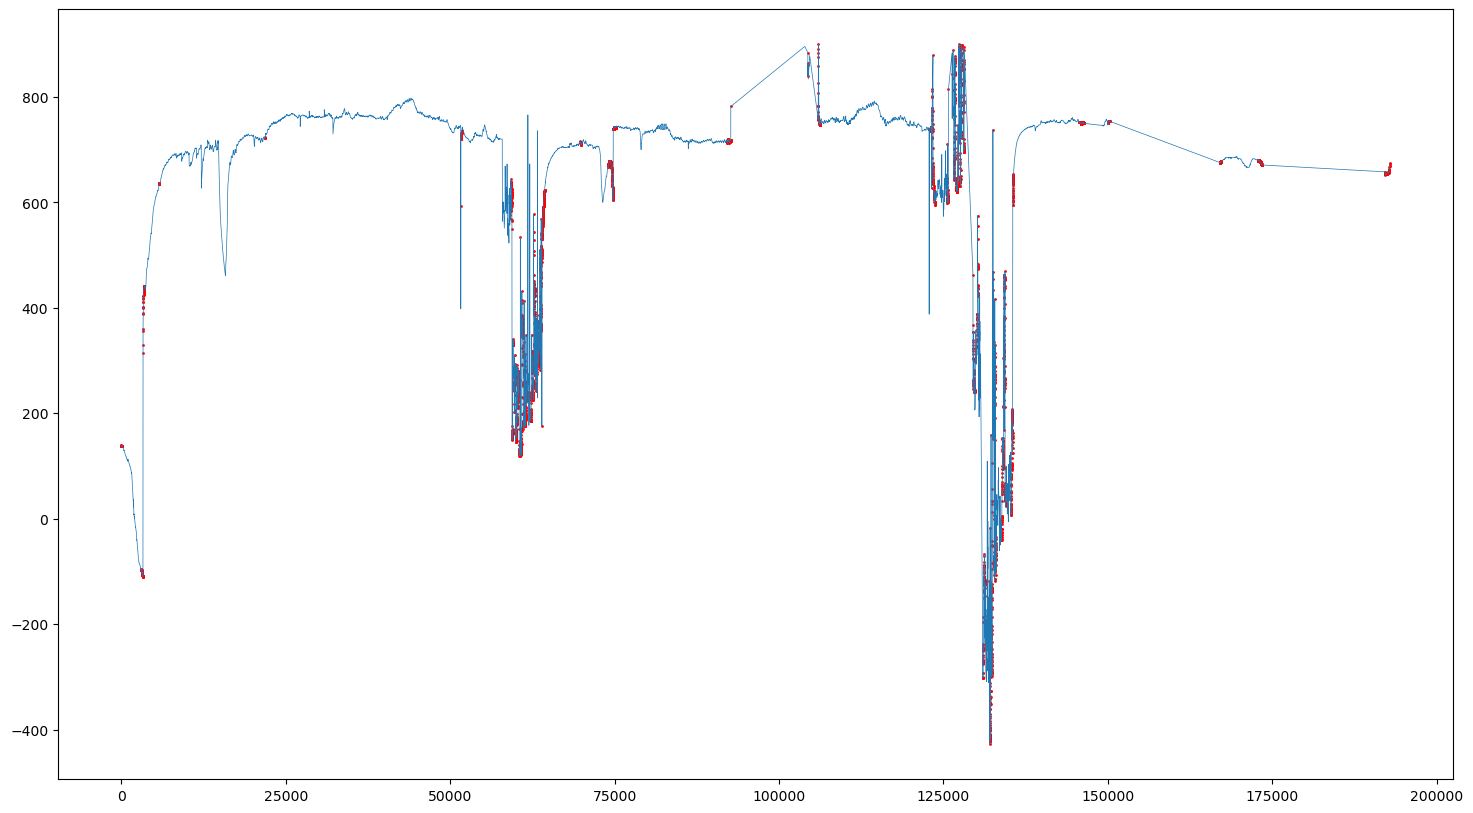

In [22]:
model_all_sensors.fit(filtered_train_X)
anomaly = model_all_sensors.predict(filtered_test_X)
plt.figure(figsize=(18,10))
plt.plot(filtered_test_X['Redox_Avg(1)'], linewidth=0.5)
plt.scatter(filtered_test_X[anomaly == True].index, filtered_test_X[anomaly == True]['Redox_Avg(1)'], s=1, c='red')

### 2023 predictions using all sensors

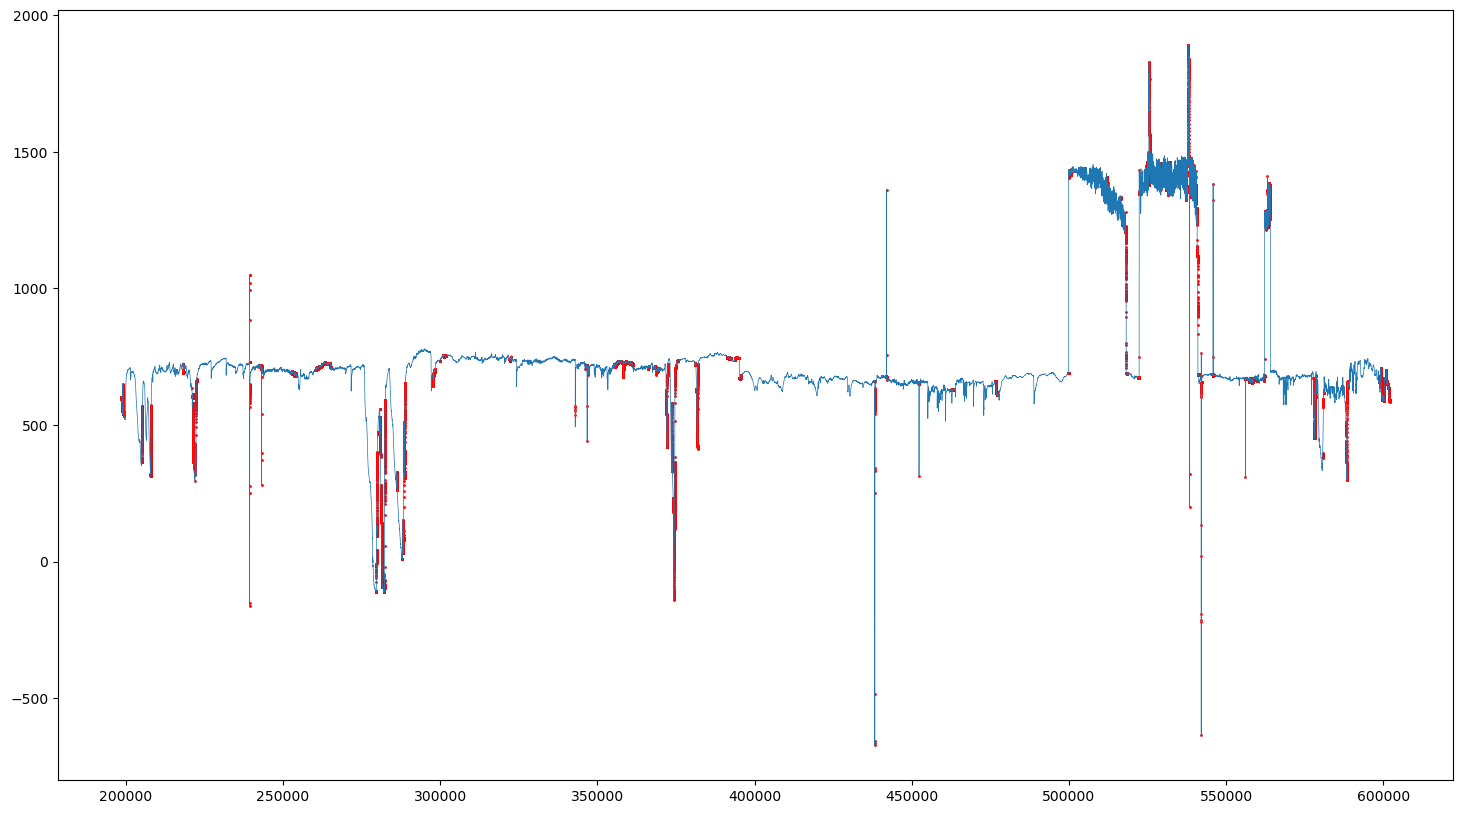

In [23]:
model_all_sensors.fit(filtered_train_X)
anomaly = model_all_sensors.predict(filtered_2023)
plt.figure(figsize=(18,10))
plt.plot(filtered_2023['Redox_Avg(1)'], linewidth=0.5)
plt.scatter(filtered_2023[anomaly == True].index, filtered_2023[anomaly == True]['Redox_Avg(1)'], s=1, c='red')

### 2022 sensor-specific test datasets

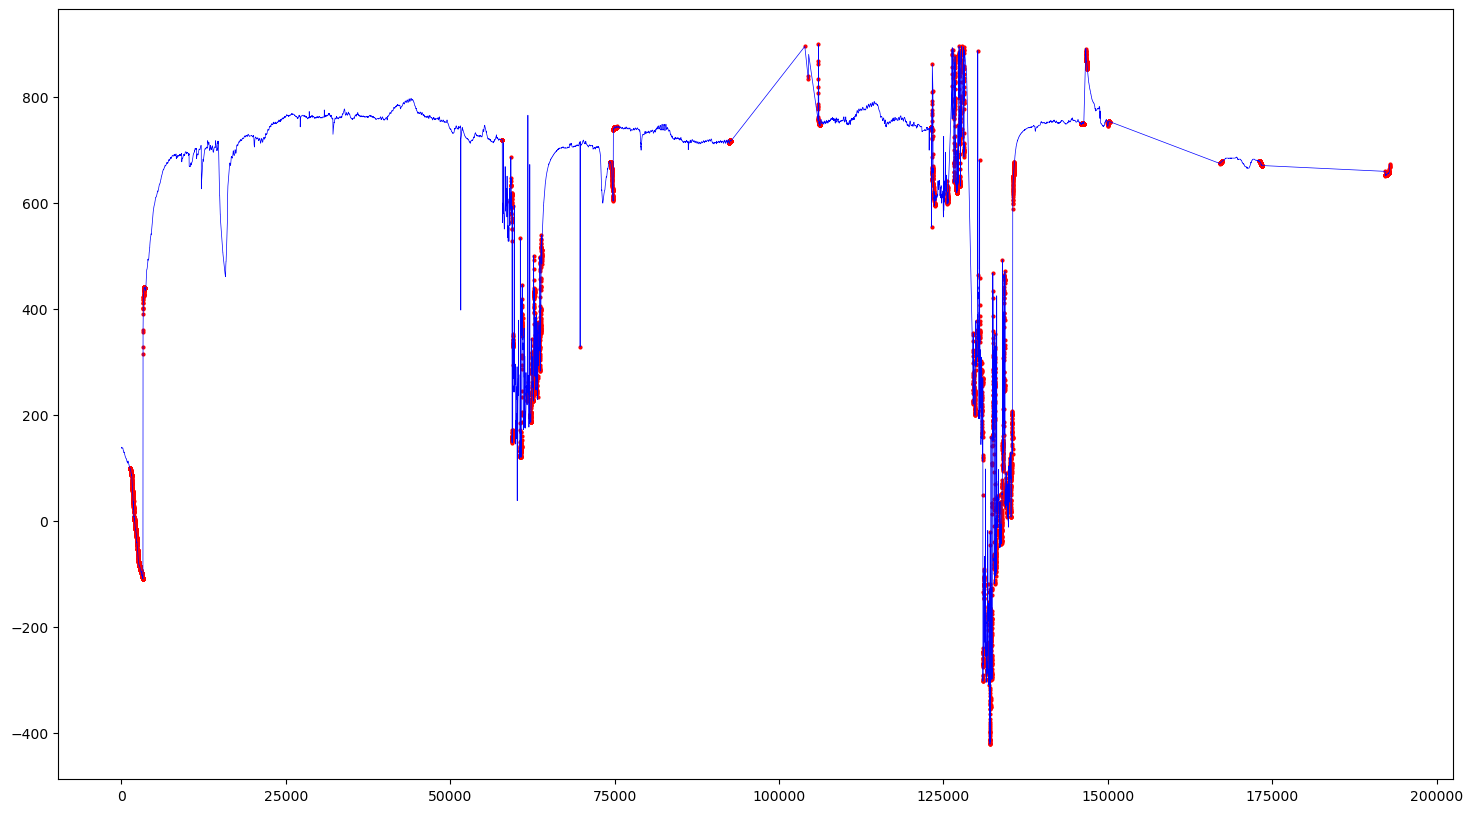

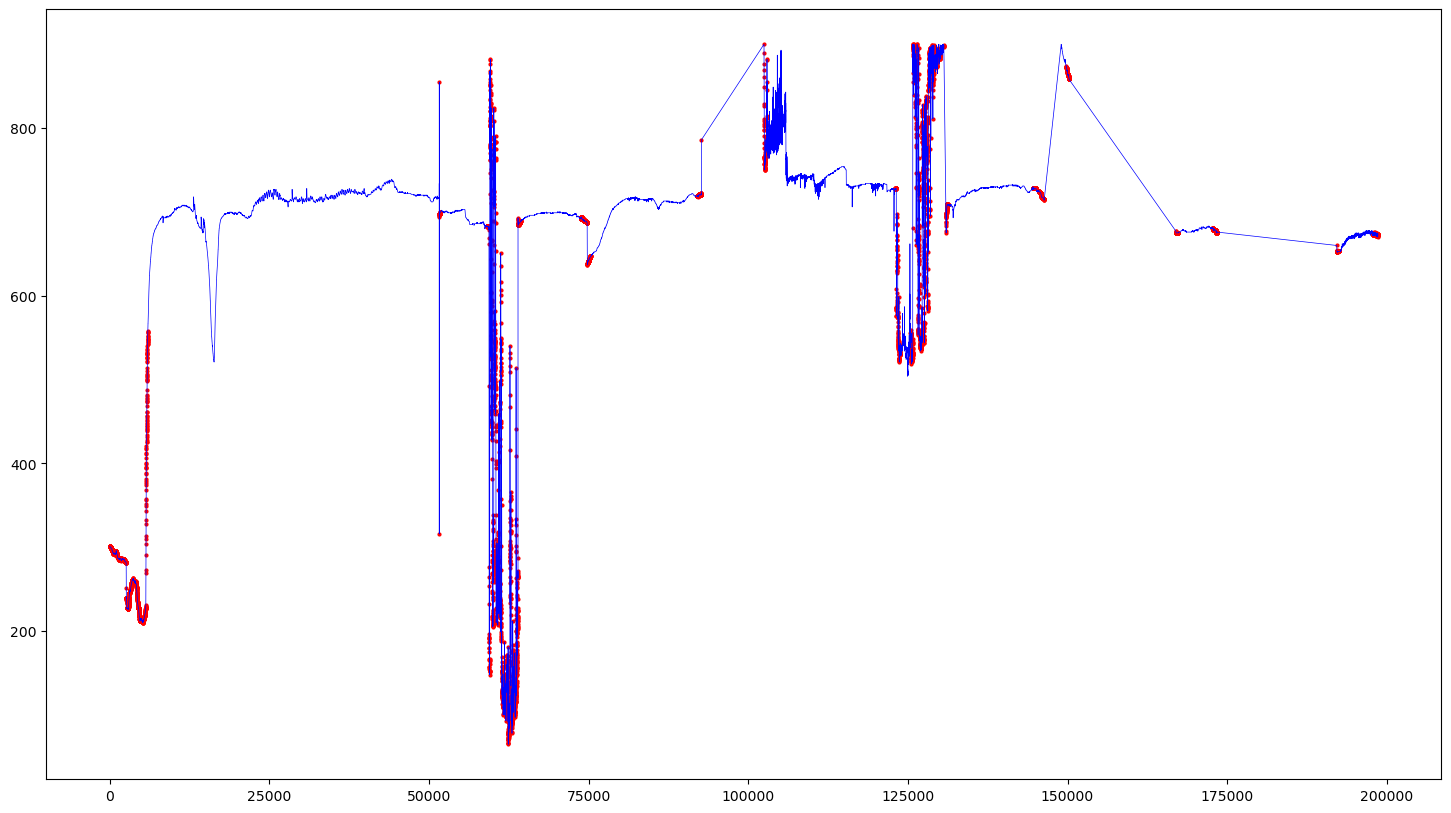

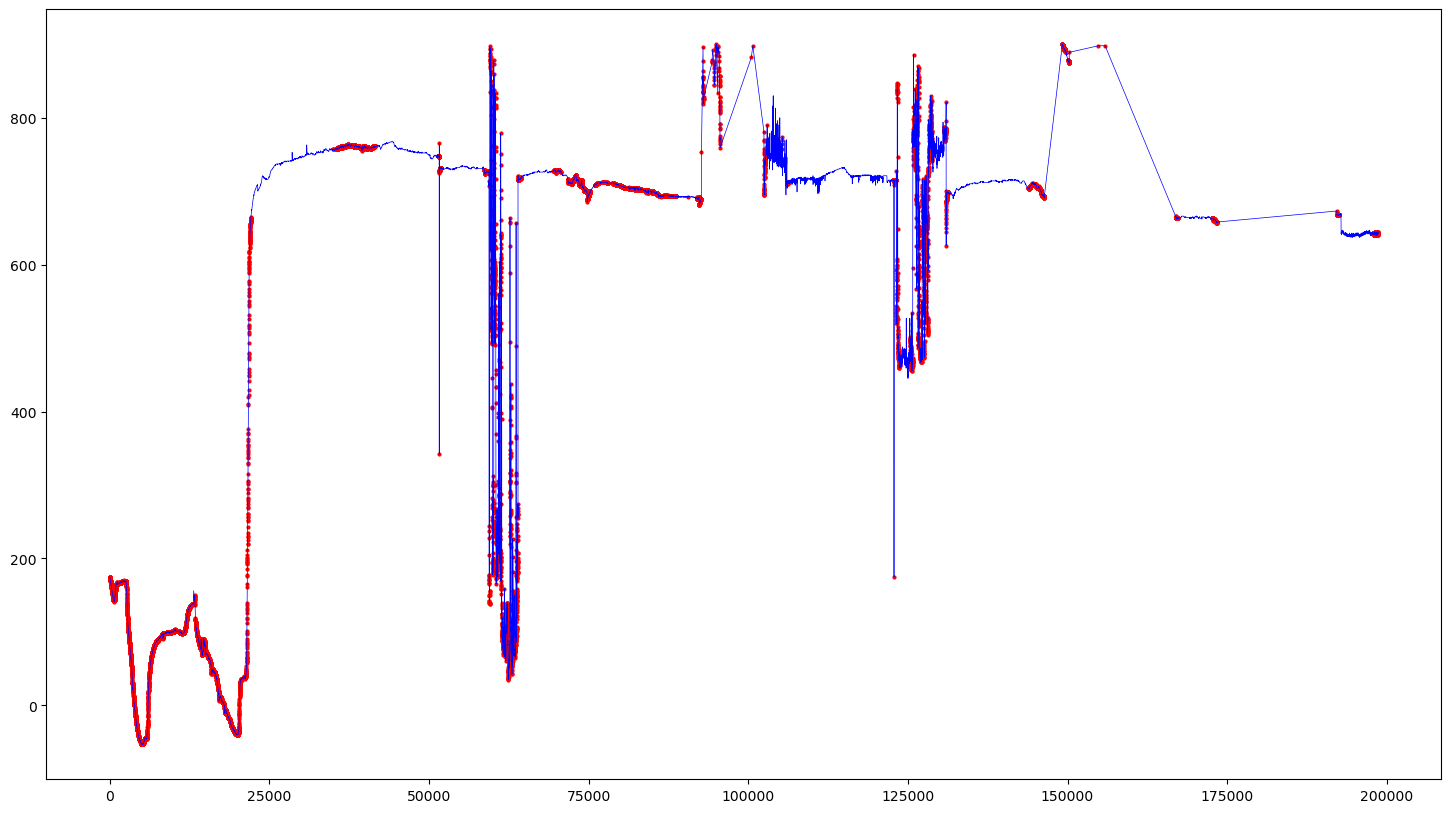

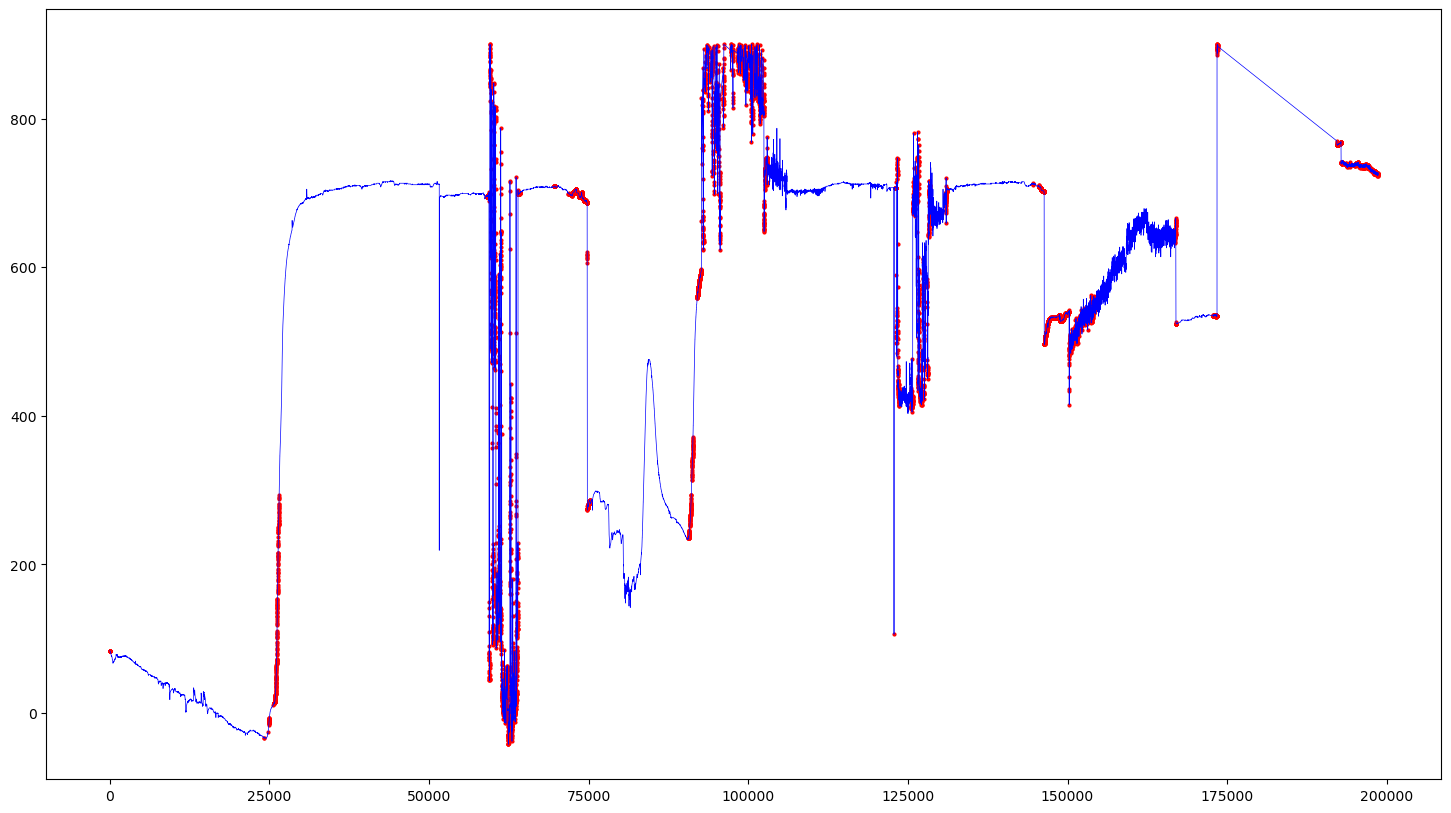

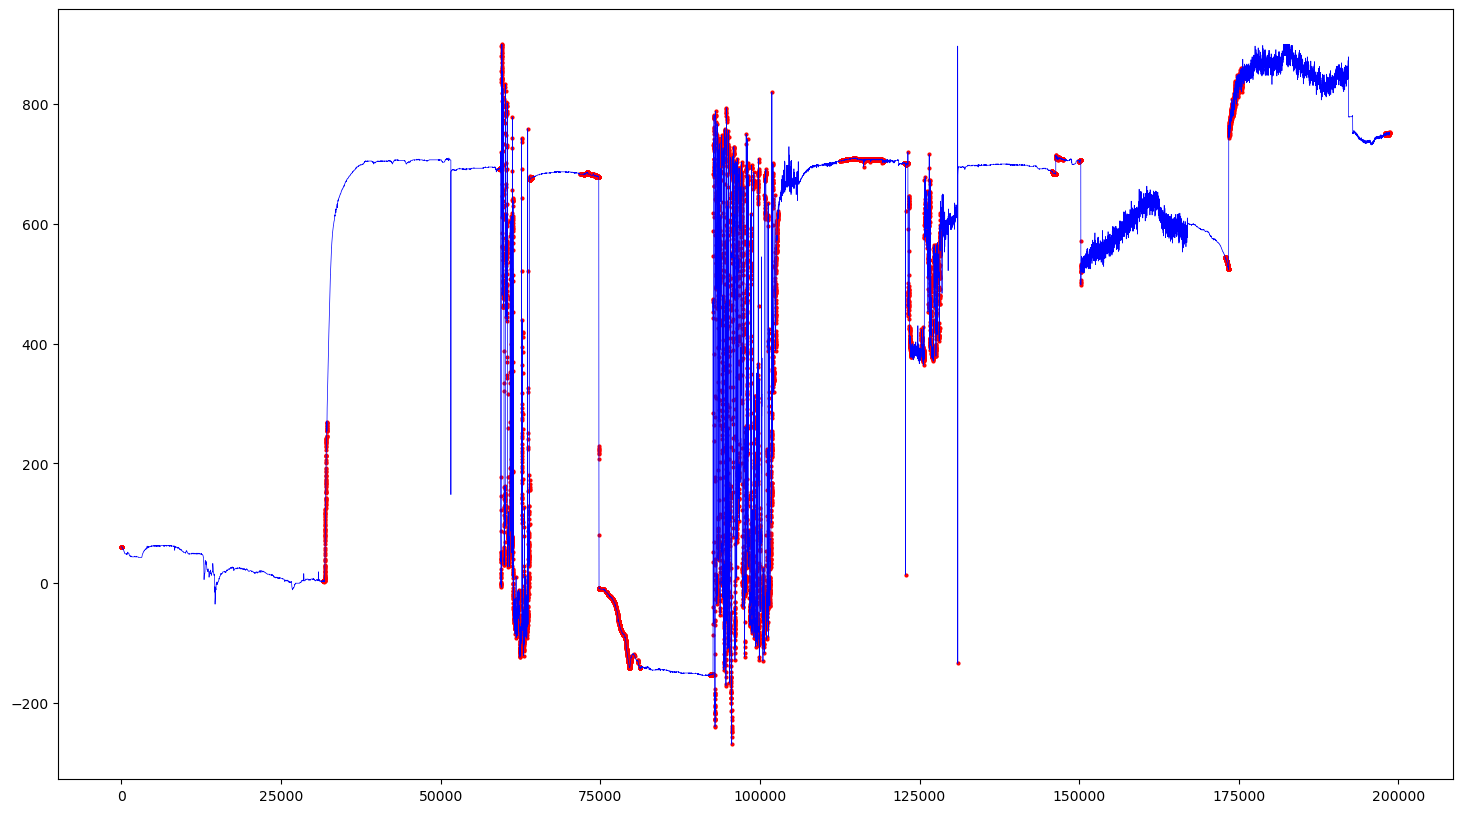

In [48]:
for d in range(1,6):
    model = sensor_models[d-1]
    fit_data = filtered_pit_train_X[d-1][pit_train_y[d-1][f'Redox_error_flag({d})'] == False]
    model.fit(fit_data)
    anomaly = model.predict(filtered_pit_test_X[d-1])

    plt.figure(figsize=(18,10))
    plt.plot(filtered_pit_test_X[d-1].index, filtered_pit_test_X[d-1][f'Redox_Avg({d})'], linewidth=0.5, c='blue')
    plt.scatter(filtered_pit_test_X[d-1][anomaly == True].index, filtered_pit_test_X[d-1][anomaly == True][f'Redox_Avg({d})'], c='red', s=4)

### 2023 sensor-specific predictions

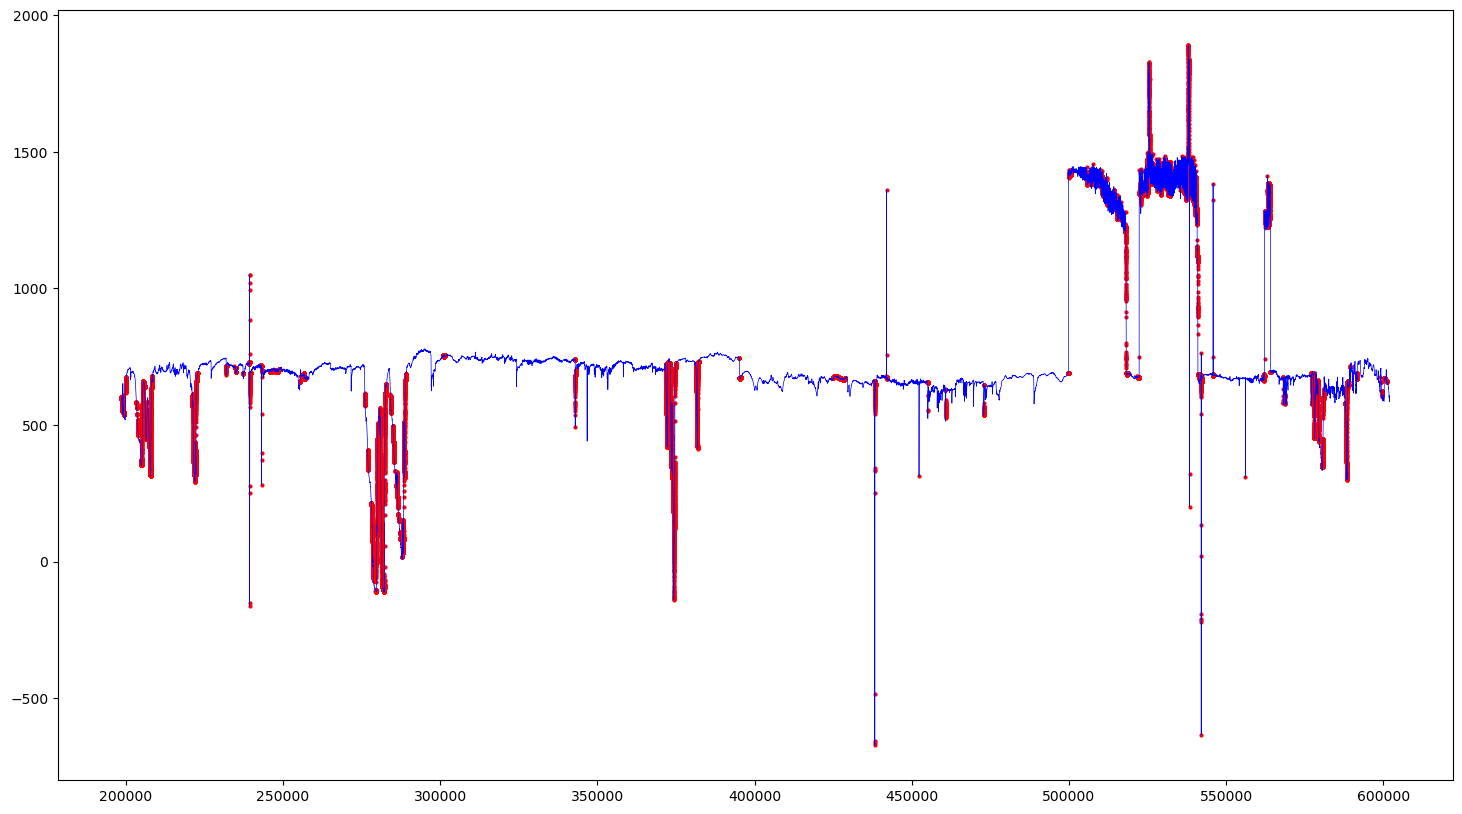

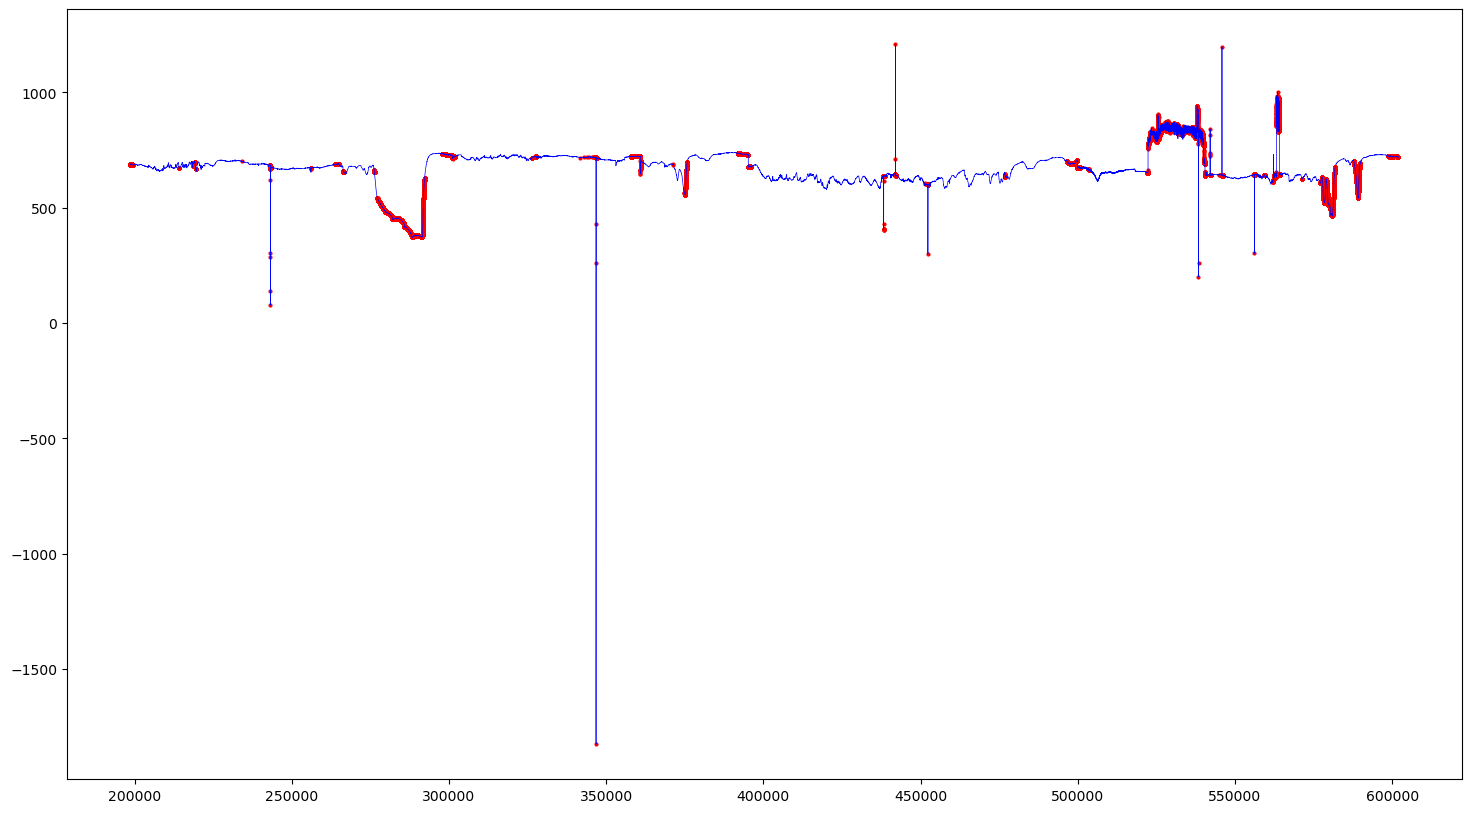

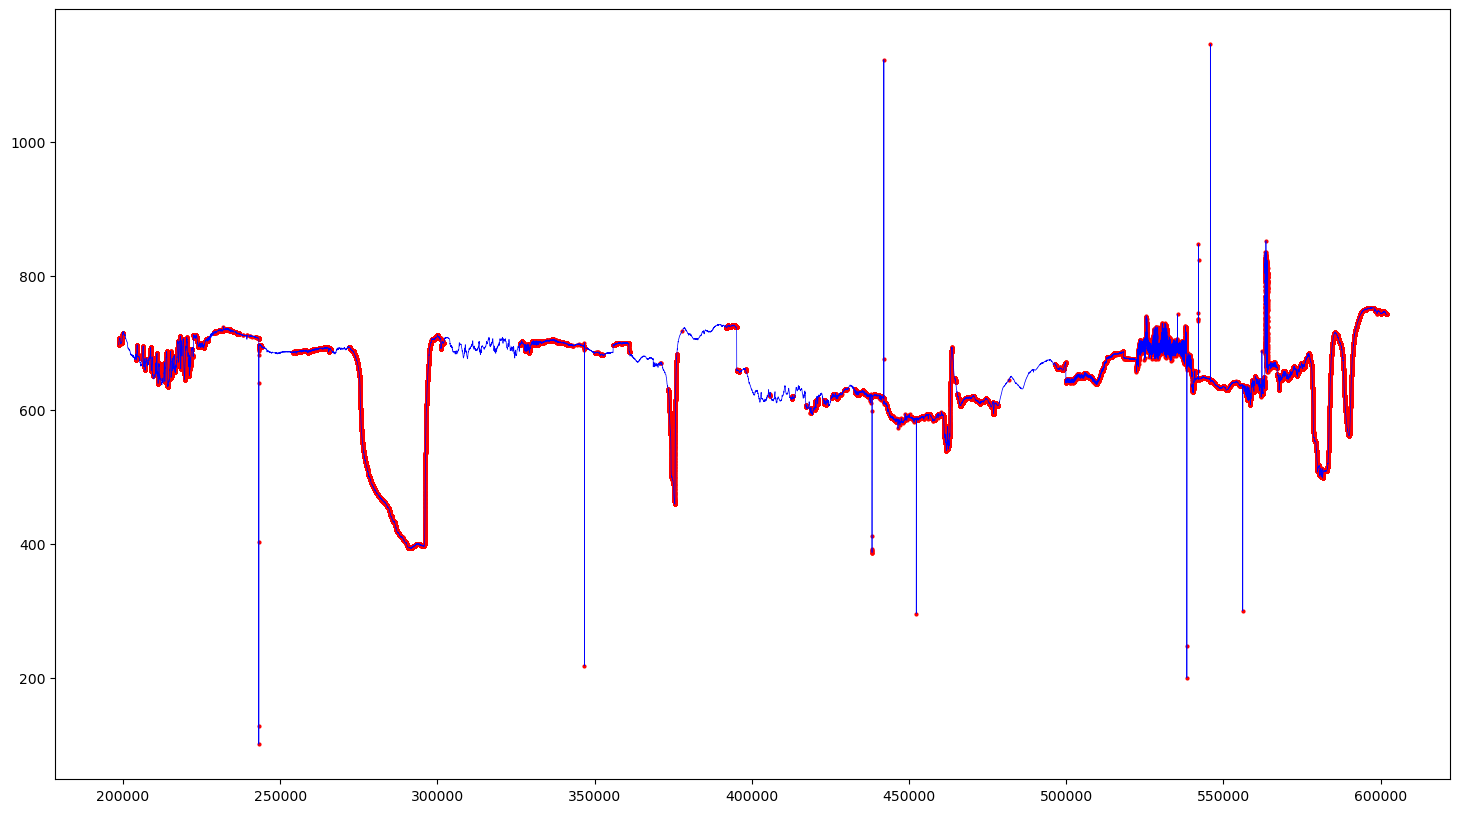

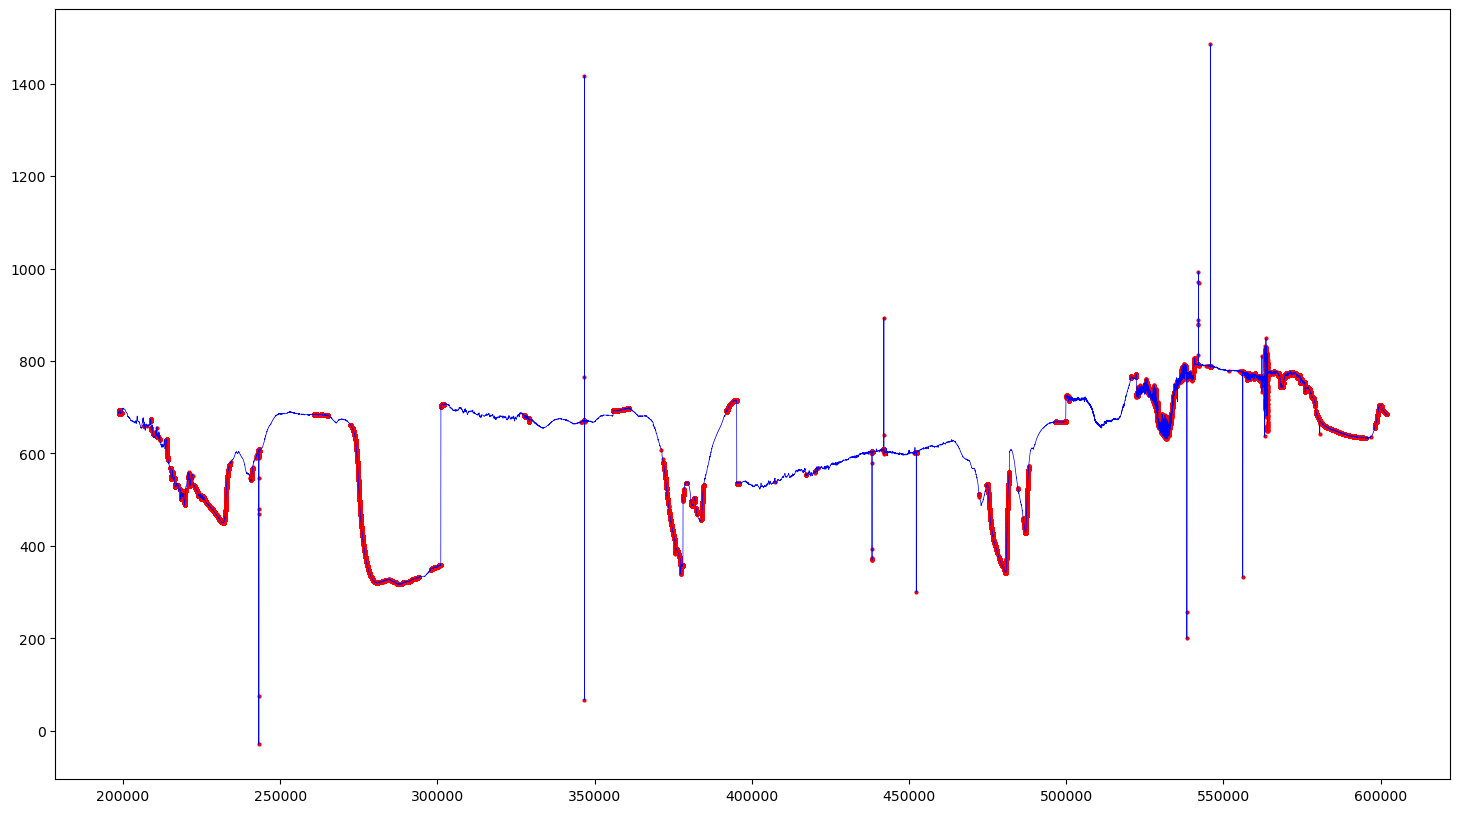

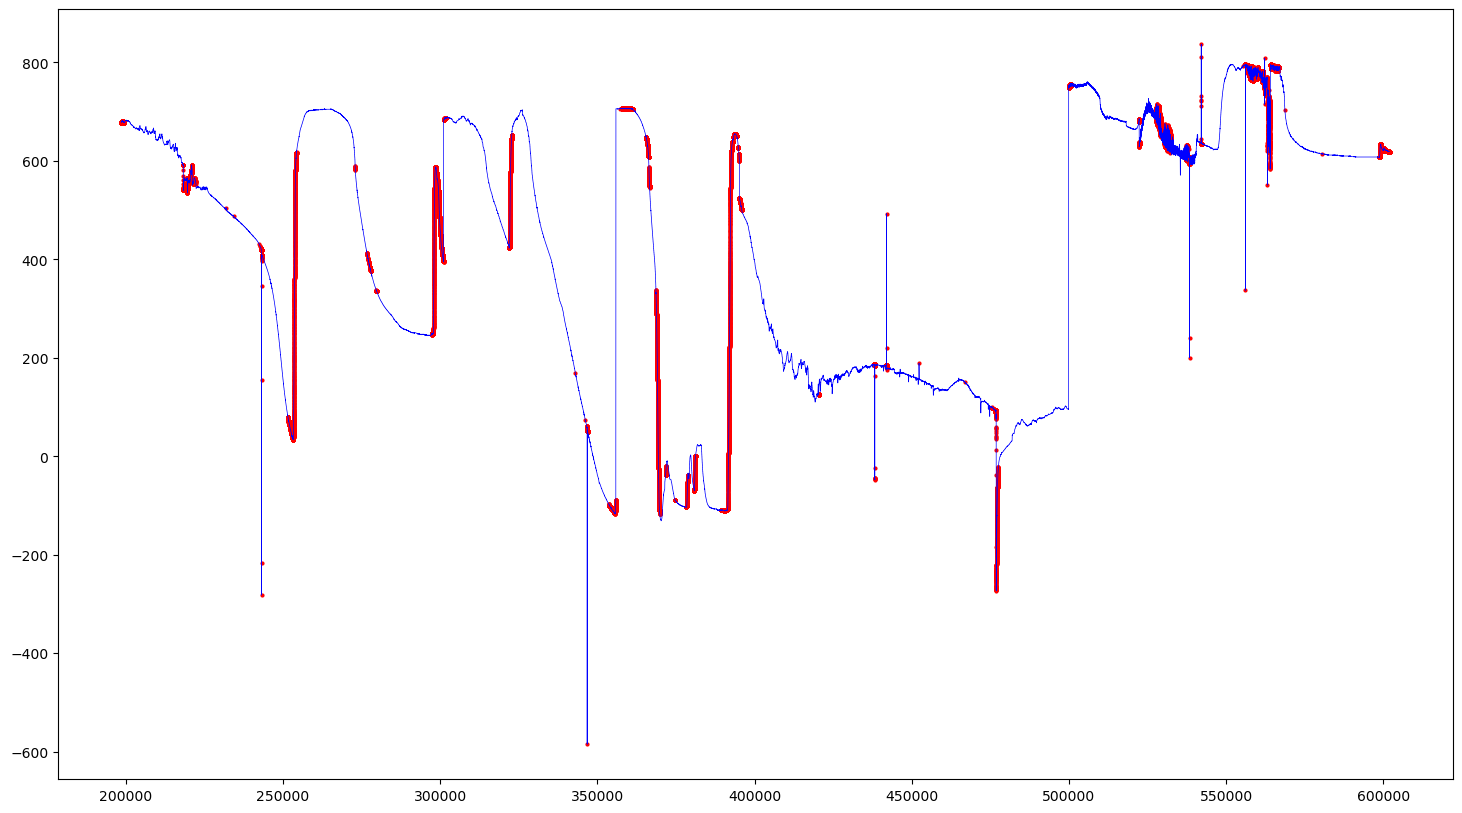

In [49]:
for d in range(1,6):
    model = sensor_models[d-1]
    fit_data = filtered_pit_train_X[d-1][pit_train_y[d-1][f'Redox_error_flag({d})'] == False]
    model.fit(fit_data)
    anomaly = model.predict(filtered_pit_test_2023[d-1])

    plt.figure(figsize=(18,10))
    plt.plot(filtered_pit_test_2023[d-1].index, filtered_pit_test_2023[d-1][f'Redox_Avg({d})'], linewidth=0.5, c='blue')
    plt.scatter(filtered_pit_test_2023[d-1][anomaly == True].index, filtered_pit_test_2023[d-1][anomaly == True][f'Redox_Avg({d})'], c='red', s=4)

### Making pickles of the best models
The contamination parameter was set to 0.1 regardless of the grid search results so that the models are consistent with the PCAGaussianMixture models. 

In [ ]:
pickle.dump(model_all_sensors, open('./pca_isolation_forest_all_sensors.pkl', 'wb'))
pickle.dump(model_sensor_1, open('./pca_isolation_forest_sensor_1.pkl', 'wb'))
pickle.dump(model_sensor_2, open('./pca_isolation_forest_sensor_2.pkl', 'wb'))
pickle.dump(model_sensor_3, open('./pca_isolation_forest_sensor_3.pkl', 'wb'))
pickle.dump(model_sensor_4, open('./pca_isolation_forest_sensor_4.pkl', 'wb'))
pickle.dump(model_sensor_5, open('./pca_isolation_forest_sensor_5.pkl', 'wb'))